# Загрузка и импорт необходимых библиотек

In [1]:
!pip install protobuf==3.20

In [2]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"]="python"

In [3]:
%%capture
!pip install bigartm

In [4]:
import numpy as np
import artm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Подключение диска

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Класс обработчик

In [43]:
class Worker_with_topics:
    def __init__(
        self,
        theta_path: str,
        model_path: str,
        news_path: str,
        news_with_true_distribution_path: str,
        column_with_true_topics: str = "tags",
        columns: list[str] = ["url", "title", "summary", "content"]
    ):
        self.theta = pd.read_excel(theta_path).iloc[:, 1:]
        self.model = artm.load_artm_model(model_path)
        self.num_topics = self.model.num_topics
        self.news = pd.read_excel(news_path)
        self.news = self.news.fillna("")
        self.news = self.news.astype(str)
        self.news_with_true_distribution = pd.read_excel(
            news_with_true_distribution_path
        )
        self.news_with_true_distribution = self.news_with_true_distribution.fillna(
            ""
        )
        self.news_with_true_distribution = self.news_with_true_distribution.astype(
            str
        )
        self.column_with_true_topics = column_with_true_topics
        self.columns = columns

        self.__calc__()

    def __calc_clear_theta__(self) -> None:
        self.clear_theta = self.theta[self.theta.sum(axis=1) != 0.0].copy(
            deep=True
        )

    def __calc_clear_news__(self) -> None:
        self.clear_news = self.news.copy(deep=True)
        self.clear_news.drop(
            self.clear_news.index.difference(self.clear_theta.index),
            inplace=True
        )

    def __calc_clear_news_with_true_distribution__(self) -> None:
        self.clear_news_with_true_distribution = self.news_with_true_distribution[
            self.news_with_true_distribution["url"].isin(
                self.clear_news["url"]
            )].copy(deep=True)

    def __reset_indecies__(self) -> None:
        self.clear_news = self.clear_news[["title", "summary",
                                           "content"]].copy(deep=True)
        self.clear_news = self.clear_news.reset_index(drop=True)

        self.clear_news_with_true_distribution = self.clear_news_with_true_distribution[
            ["title", "summary", "content", "tags"]].copy(deep=True)
        self.clear_news_with_true_distribution[
            "tags"] = self.clear_news_with_true_distribution["tags"].apply(
                lambda x: x.split()[0] if x else ""
            )
        self.clear_news_with_true_distribution = self.clear_news_with_true_distribution.reset_index(
            drop=True
        )

        self.clear_theta = self.clear_theta.reset_index(drop=True)

    def __calc_absolute_theta__(self) -> None:
        self.absolute_theta = self.clear_theta.copy(deep=True)

        for row in range(self.absolute_theta.shape[0]):
            max_in_row = max(self.absolute_theta.loc[row, :])
            for column in self.absolute_theta.columns:
                self.absolute_theta.loc[
                    row, column] = 1.0 if self.absolute_theta.loc[
                        row, column] == max_in_row else 0.0

    def __calc_defuzzification_threshold__(self) -> None:
        self.defuzzification_threshold = min(
            [
                max(self.clear_theta.loc[row, :])
                for row in range(self.clear_theta.shape[0])
            ]
        )

    def __calc_defuzzification_theta__(self) -> None:
        self.defuzzification_theta = self.clear_theta.copy(deep=True)

        for row in range(self.defuzzification_theta.shape[0]):
            for column in self.defuzzification_theta.columns:
                value = self.defuzzification_theta.loc[row, column]

                self.defuzzification_theta.loc[
                    row, column
                ] = value if value >= self.defuzzification_threshold else 0.0

    def __calc_topic_news_from_theta__(
        self, num_of_topic: int, theta: pd.DataFrame
    ) -> set[int]:
        news = set()

        for row in range(theta.shape[0]):
            if theta.iloc[row, num_of_topic] > 0.0:
                news.add(row)

        return news

    def __calc_intersection_of_topics__(
        self, theta: pd.DataFrame
    ) -> pd.DataFrame:
        topics_news = [
            self.__calc_topic_news_from_theta__(num_of_topic, theta)
            for num_of_topic in range(self.num_topics)
        ]

        intersection_of_themes = pd.DataFrame(
            index=theta.columns, columns=theta.columns
        )

        for this_topic in range(self.num_topics):
            for other_topic in range(self.num_topics):
                intersection_of_themes.loc[
                    theta.columns[this_topic],
                    theta.columns[other_topic]] = len(
                        topics_news[this_topic].intersection(
                            topics_news[other_topic]
                        )
                    ) * 1.0 / (len(topics_news[this_topic]) + 0.0000001)

        return intersection_of_themes.astype(float)

    def __calc_topics_news_from_theta__(self, theta: pd.DataFrame) -> list[int]:
        return [
            len(self.__calc_topic_news_from_theta__(num_of_topic, theta))
            for num_of_topic in range(self.num_topics)
        ]

    def __calc_labeled_news__(self) -> None:
        self.labeled_news = self.clear_news.copy(deep=True)

        topic_names = {
            key: value
            for key, value in
            zip(self.absolute_theta.columns, self.absolute_theta.columns)
        }

        self.labeled_news["topic"] = self.absolute_theta.idxmax(axis=1)
        self.labeled_news["topic"] = self.labeled_news["topic"].map(topic_names)

    def __calc_docs_topics_theta__(self) -> None:
        temp = dict()

        for row in range(self.labeled_news.shape[0]):
            topic = self.labeled_news.loc[row, "topic"]

            if topic in temp.keys():
                temp[topic].append(row)
            else:
                temp[topic] = [row]

        self.docs_topics_theta = [temp[key] for key in temp]
        self.docs_topics_theta = sorted(self.docs_topics_theta, key=len)[::-1]

    def __calc_docs_topics_true_distribution__(self) -> None:
        temp = dict()

        for row in range(self.clear_news_with_true_distribution.shape[0]):
            topic = self.clear_news_with_true_distribution.loc[row, "tags"]

            if topic in temp.keys():
                temp[topic].append(row)
            else:
                temp[topic] = [row]

        self.docs_topics_true_distribution = [temp[key] for key in temp]
        self.docs_topics_true_distribution = sorted(
            self.docs_topics_true_distribution, key=len
        )[::-1]

    def __calc_difference_between_distributions__(self) -> None:
        if len(self.docs_topics_theta) > len(
            self.docs_topics_true_distribution
        ):
            for _ in range(
                len(self.docs_topics_theta) -
                len(self.docs_topics_true_distribution)
            ):
                self.docs_topics_true_distribution.append([])
        elif len(self.docs_topics_theta) < len(
            self.docs_topics_true_distribution
        ):
            for _ in range(
                len(self.docs_topics_true_distribution) -
                len(self.docs_topics_theta)
            ):
                self.docs_topics_theta.append([])

        total_elements = 0
        matching_elements = 0

        for sublist1, sublist2 in zip(
            self.docs_topics_theta, self.docs_topics_true_distribution
        ):
            set1 = set(sublist1)
            set2 = set(sublist2)

            common = set1 & set2
            matching_elements += len(common)
            total_elements += len(set1)

        if total_elements == 0:
            return 0.0

        self.difference_between_distributions = 100 - (
            matching_elements / total_elements
        ) * 100

    def __calc__(self) -> None:
        self.__calc_clear_theta__()
        self.__calc_clear_news__()
        self.__calc_clear_news_with_true_distribution__()
        self.__reset_indecies__()
        self.__calc_absolute_theta__()
        self.__calc_defuzzification_threshold__()
        self.__calc_defuzzification_theta__()
        self.__calc_labeled_news__()
        self.__calc_docs_topics_theta__()
        self.__calc_docs_topics_true_distribution__()
        self.__calc_difference_between_distributions__()

    def show_intersection_of_topics(self) -> None:
        intersection_of_themes = self.__calc_intersection_of_topics__(
            self.defuzzification_theta
        )

        sns.heatmap(intersection_of_themes, annot=True)
        plt.show()

    def show_number_of_news_in_topics(self) -> None:
        absolute_news_in_topics = self.__calc_topics_news_from_theta__(
            self.absolute_theta
        )
        news_in_topics = self.__calc_topics_news_from_theta__(
            self.defuzzification_theta
        )
        themes = self.defuzzification_theta.columns

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        rects1 = ax1.bar(themes, absolute_news_in_topics, color='skyblue')
        ax1.set_ylabel('Количество новостей')
        ax1.set_title('Абсолютное распределение новостей по темам')
        ax1.tick_params(axis='x', rotation=45)

        rects2 = ax2.bar(themes, news_in_topics, color='salmon')
        ax2.set_ylabel('Количество новостей')
        ax2.set_title('Нормированное распределение новостей по темам')
        ax2.tick_params(axis='x', rotation=45)

        def autolabel(rects, ax):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(
                    '{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center',
                    va='bottom'
                )

        autolabel(rects1, ax1)
        autolabel(rects2, ax2)

        plt.tight_layout()
        plt.show()

    def show_topics_words_cores(self) -> None:
        topics_words_cores = self.model.score_tracker["top_tokens"].last_tokens

        for key in topics_words_cores:
            print(f"{key}: {topics_words_cores[key]}")

    def get_labeled_news(self) -> pd.DataFrame:
        return self.labeled_news.copy(deep=True)

    def save_labeled_news(
        self, labeled_news_path: str = "./labeled_newx.xlsx"
    ) -> None:
        self.labeled_news.to_excel(labeled_news_path)

    def show_difference_between_distributions(self) -> None:
        print(self.difference_between_distributions)

# Разбор характеристик обучения тематических моделей и формирование размеченных данных

## Модель без tfidf слов

Создаём экземпляр класса

In [49]:
theta_path = "./drive/MyDrive/theta.xlsx"
model_path = "./drive/MyDrive/model"
news_path = "./prepeared_news_without_tfidf.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt = Worker_with_topics(theta_path, model_path, news_path, news_with_true_distribution_path)

Полученные характеристики

In [50]:
wwt.show_topics_words_cores()

topic_0: ['наука', 'институт', 'работать', 'экономический', 'конференция', 'анализ', 'учёный', 'преподаватель', 'язык', 'лаборатория']
topic_1: ['вуз', 'курс', 'онлайн', 'работать', 'хороший', 'уровень', 'образовательный', 'получить', 'учиться', 'возможность']
topic_2: ['общество', 'социальный', 'центр', 'вопрос', 'проблема', 'мир', 'результат', 'важный', 'профессор', 'время']
topic_3: ['бизнес', 'система', 'место', 'обучение', 'международный', 'центр', 'направление', 'город', 'технология', 'рамка']
topic_4: ['олимпиада', 'вуз', 'получить', 'участник', 'конкурс', 'возможность', 'время', 'результат', 'приём', 'победитель']
topic_5: ['область', 'наука', 'знание', 'технология', 'экономический', 'преподаватель', 'уровень', 'место', 'компания', 'деятельность']
topic_6: ['вопрос', 'международный', 'бизнес', 'политика', 'социальный', 'получить', 'система', 'рынок', 'мировой', 'управление']


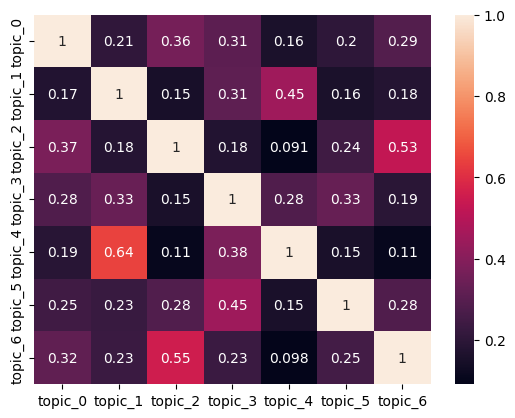

In [51]:
wwt.show_intersection_of_topics()

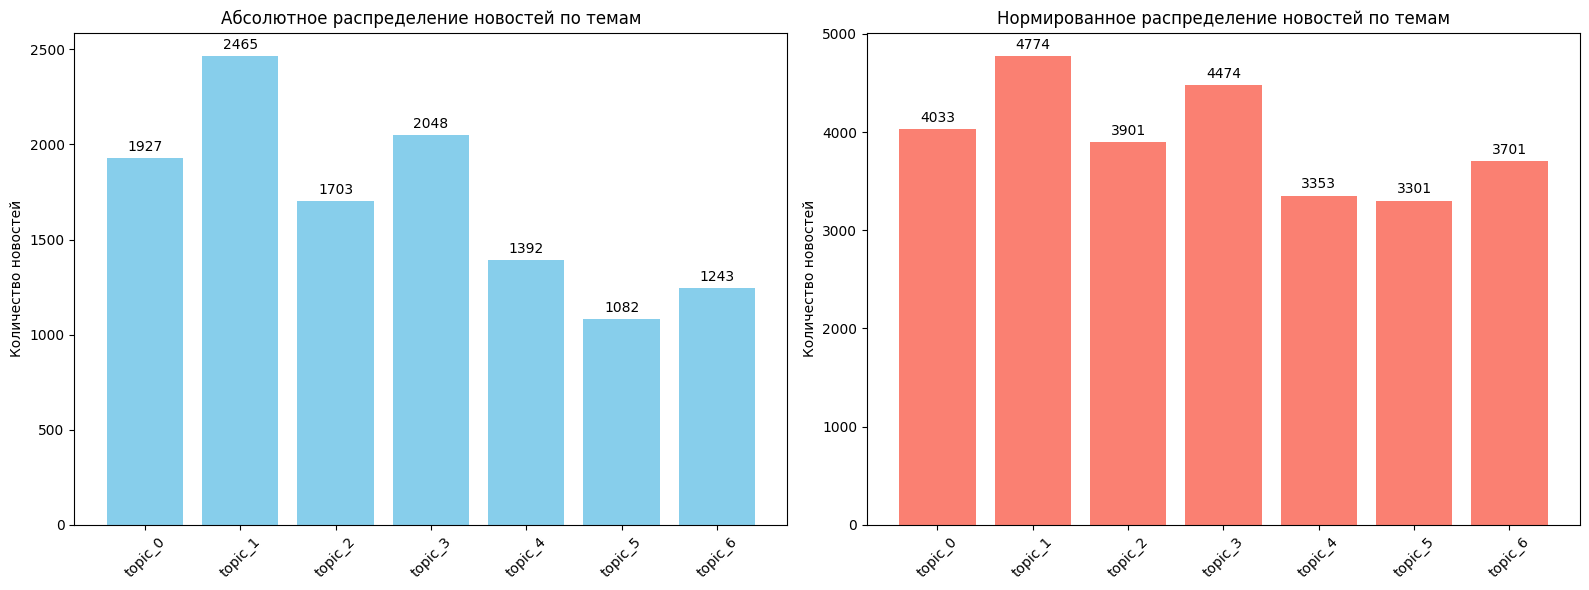

In [52]:
wwt.show_number_of_news_in_topics()

In [53]:
wwt.show_difference_between_distributions()

85.12647554806071


Сохранение размеченных данных

In [54]:
wwt.save_labeled_news("./labeled_news.xlsx")

## Модель с tfidf стоп-словами 1 процент

Создаём экземпляр класса

In [55]:
theta_tfidf_1_path = "./drive/MyDrive/theta_tfidf_1.xlsx"
model_tfidf_1_path = "./drive/MyDrive/model_tfidf_1"
news_tfidf_1_path = "./prepeared_news_with_tfidf_1.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_1 = Worker_with_topics(theta_tfidf_1_path, model_tfidf_1_path, news_tfidf_1_path, news_with_true_distribution_path)

Полученные характеристики

In [56]:
wwt_tfidf_1.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'институт', 'профессор', 'анализ', 'преподаватель', 'курс', 'конференция']
topic_1: ['курс', 'вуз', 'онлайн', 'учиться', 'хороший', 'работать', 'студенческий', 'день', 'время', 'обучение']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'рост', 'гражданский', 'политический', 'гу', 'организация', 'сектор']
topic_3: ['бизнес', 'обучение', 'компания', 'система', 'международный', 'управление', 'технология', 'образовательный', 'сфера', 'область']
topic_4: ['олимпиада', 'участник', 'школьник', 'получить', 'класс', 'победитель', 'конкурс', 'возможность', 'поступление', 'магистратура']
topic_5: ['область', 'центр', 'деятельность', 'государственный', 'организация', 'знание', 'технология', 'экономический', 'уровень', 'институт']
topic_6: ['политика', 'мировой', 'рынок', 'государство', 'вопрос', 'экономический', 'система', 'международный', 'отношение', 'проблема']
topic_7: ['место', 'вуз', 'город', 'конкурс', 'рейтинг', 'москва', 'абит

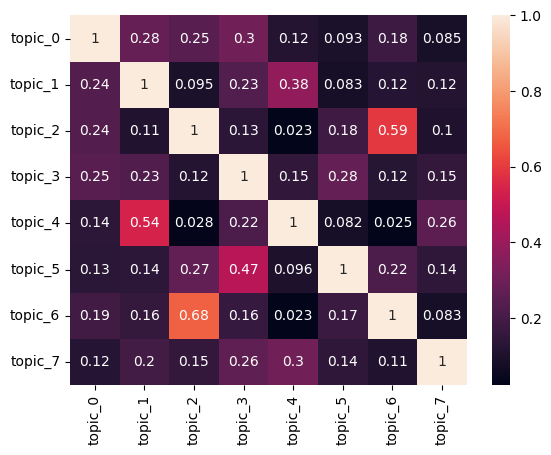

In [57]:
wwt_tfidf_1.show_intersection_of_topics()

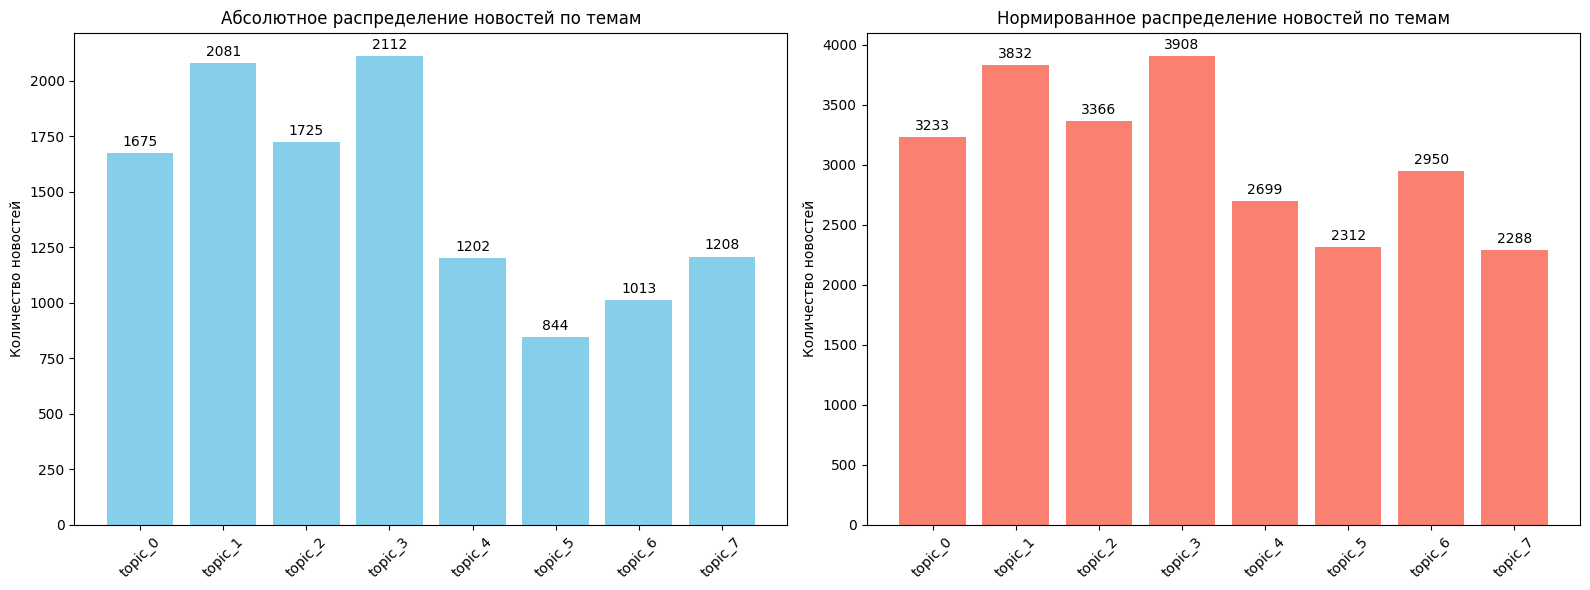

In [58]:
wwt_tfidf_1.show_number_of_news_in_topics()

In [59]:
wwt_tfidf_1.show_difference_between_distributions()

85.79258010118043


Сохранение размеченных данных

In [60]:
wwt_tfidf_1.save_labeled_news("./labeled_tfidf_1_news.xlsx")

## Модель c tfidf стоп-словами 2 процента

Создаём экземпляр класса

In [61]:
theta_tfidf_2_path = "./drive/MyDrive/theta_tfidf_2.xlsx"
model_tfidf_2_path = "./drive/MyDrive/model_tfidf_2"
news_tfidf_2_path = "./prepeared_news_with_tfidf_2.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_2 = Worker_with_topics(theta_tfidf_2_path, model_tfidf_2_path, news_tfidf_2_path, news_with_true_distribution_path)

Полученные характеристики

In [62]:
wwt_tfidf_2.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'институт', 'анализ', 'преподаватель', 'курс', 'профессор', 'конференция']
topic_1: ['курс', 'вуз', 'онлайн', 'учиться', 'хороший', 'работать', 'студенческий', 'день', 'обучение', 'возможность']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'рост', 'гражданский', 'политический', 'гу', 'сектор', 'организация']
topic_3: ['бизнес', 'обучение', 'компания', 'система', 'международный', 'технология', 'управление', 'образовательный', 'сфера', 'направление']
topic_4: ['олимпиада', 'участник', 'школьник', 'получить', 'класс', 'победитель', 'конкурс', 'возможность', 'поступление', 'магистратура']
topic_5: ['область', 'деятельность', 'знание', 'центр', 'государственный', 'экономический', 'организация', 'технология', 'уровень', 'институт']
topic_6: ['политика', 'мировой', 'рынок', 'вопрос', 'государство', 'экономический', 'международный', 'система', 'отношение', 'социальный']
topic_7: ['место', 'вуз', 'город', 'конкурс', 'рейтинг', 'мо

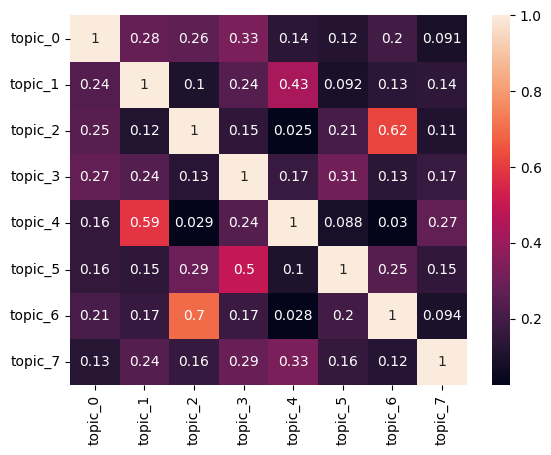

In [63]:
wwt_tfidf_2.show_intersection_of_topics()

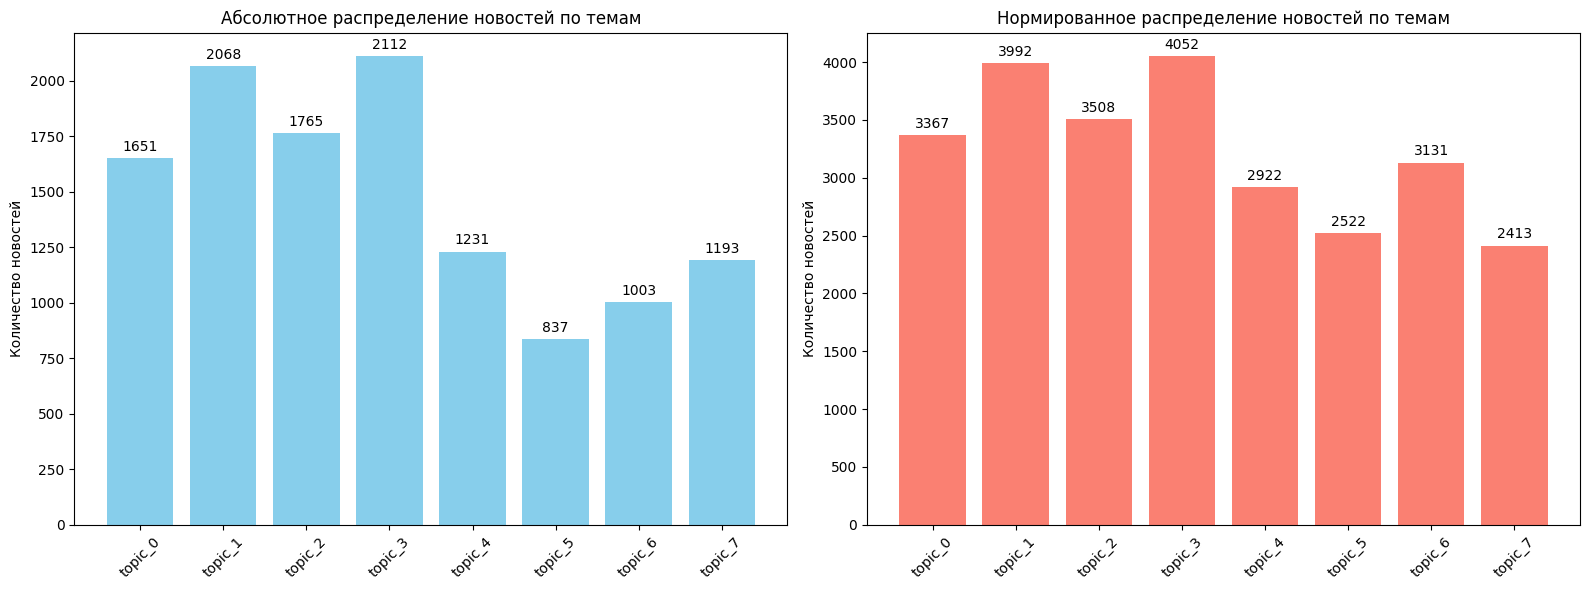

In [64]:
wwt_tfidf_2.show_number_of_news_in_topics()

In [65]:
wwt_tfidf_2.show_difference_between_distributions()

86.09612141652613


Сохранение размеченных данных

In [66]:
wwt_tfidf_2.save_labeled_news("./labeled_tfidf_2_news.xlsx")

## Модель с tfidf стоп-словами 3 процента

Создаём экземпляр класса

In [67]:
theta_tfidf_3_path = "./drive/MyDrive/theta_tfidf_3.xlsx"
model_tfidf_3_path = "./drive/MyDrive/model_tfidf_3"
news_tfidf_3_path = "./prepeared_news_with_tfidf_3.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_3 = Worker_with_topics(theta_tfidf_3_path, model_tfidf_3_path, news_tfidf_3_path, news_with_true_distribution_path)

Полученные характеристики

In [68]:
wwt_tfidf_3.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'институт', 'преподаватель', 'курс', 'анализ', 'профессор', 'конференция']
topic_1: ['курс', 'вуз', 'онлайн', 'учиться', 'хороший', 'студенческий', 'работать', 'день', 'лекция', 'команда']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'гражданский', 'рост', 'политический', 'гу', 'сектор', 'организация']
topic_3: ['бизнес', 'обучение', 'компания', 'система', 'международный', 'технология', 'управление', 'образовательный', 'сфера', 'область']
topic_4: ['олимпиада', 'участник', 'школьник', 'получить', 'класс', 'победитель', 'конкурс', 'возможность', 'поступление', 'магистратура']
topic_5: ['область', 'деятельность', 'знание', 'центр', 'государственный', 'экономический', 'организация', 'технология', 'уровень', 'институт']
topic_6: ['политика', 'мировой', 'рынок', 'вопрос', 'государство', 'экономический', 'международный', 'система', 'отношение', 'социальный']
topic_7: ['место', 'вуз', 'город', 'конкурс', 'рейтинг', 'москва', 'аб

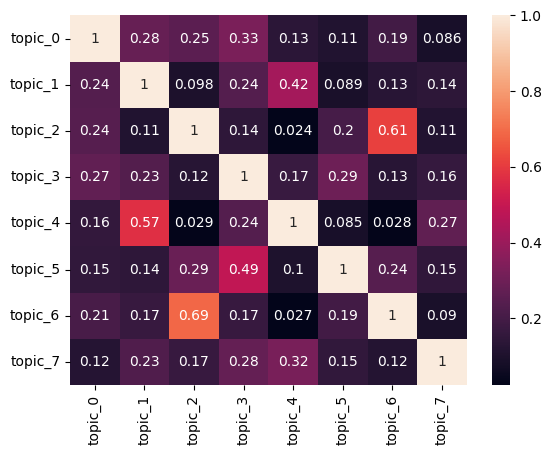

In [69]:
wwt_tfidf_3.show_intersection_of_topics()

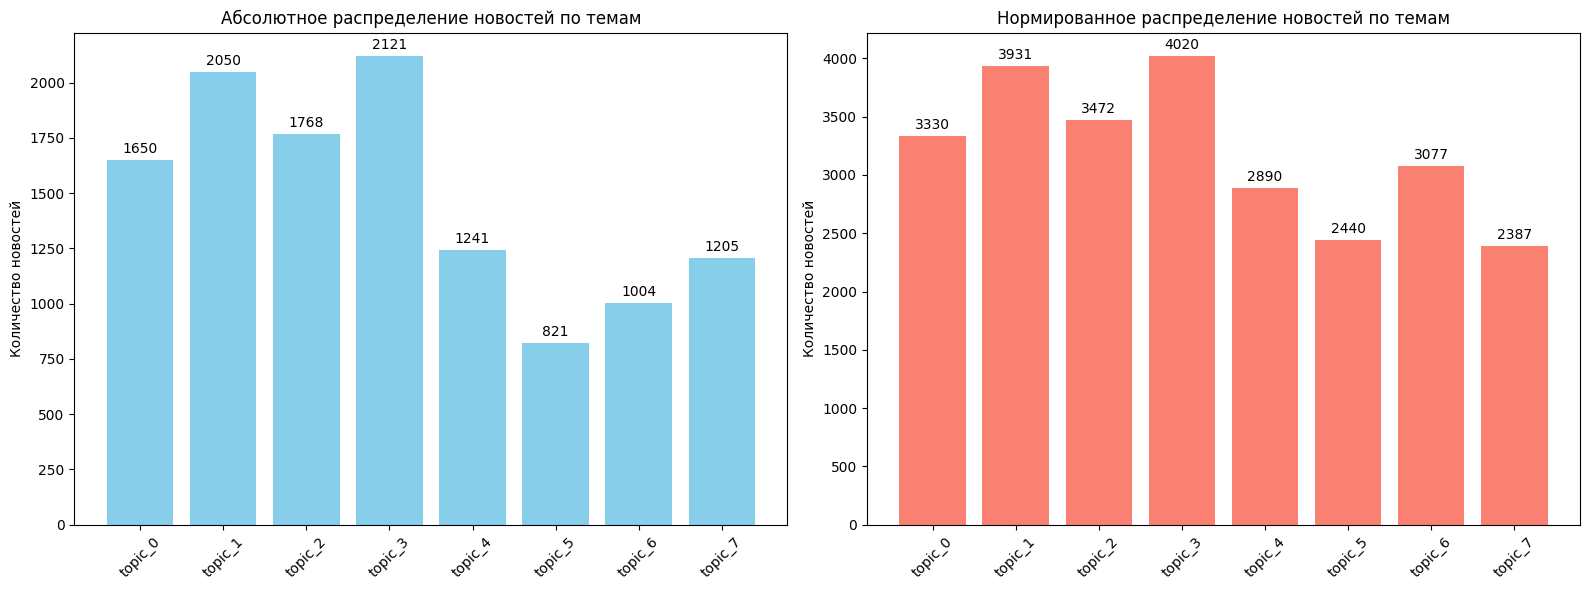

In [70]:
wwt_tfidf_3.show_number_of_news_in_topics()

In [71]:
wwt_tfidf_3.show_difference_between_distributions()

84.67959527824621


Сохранение размеченных данных

In [72]:
wwt_tfidf_3.save_labeled_news("./labeled_tfidf_3_news.xlsx")

## Модель с tfidf стоп-словами 4 процента

Создаём экземпляр класса

In [73]:
theta_tfidf_4_path = "./drive/MyDrive/theta_tfidf_4.xlsx"
model_tfidf_4_path = "./drive/MyDrive/model_tfidf_4"
news_tfidf_4_path = "./prepeared_news_with_tfidf_4.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_4 = Worker_with_topics(theta_tfidf_4_path, model_tfidf_4_path, news_tfidf_4_path, news_with_true_distribution_path)

Полученные характеристики

In [74]:
wwt_tfidf_4.show_topics_words_cores()

topic_0: ['наука', 'институт', 'конференция', 'экономический', 'учёный', 'анализ', 'лаборатория', 'работать', 'язык', 'преподаватель']
topic_1: ['вуз', 'курс', 'онлайн', 'учиться', 'хороший', 'работать', 'образовательный', 'мир', 'уровень', 'магистратура']
topic_2: ['общество', 'социальный', 'проблема', 'центр', 'вопрос', 'мир', 'профессор', 'гу', 'гражданский', 'финансовый']
topic_3: ['бизнес', 'место', 'система', 'обучение', 'международный', 'направление', 'город', 'центр', 'технология', 'рамка']
topic_4: ['олимпиада', 'вуз', 'получить', 'участник', 'конкурс', 'победитель', 'абитуриент', 'школьник', 'приём', 'возможность']
topic_5: ['область', 'наука', 'знание', 'экономический', 'технология', 'компания', 'преподаватель', 'деятельность', 'уровень', 'международный']
topic_6: ['вопрос', 'международный', 'бизнес', 'политика', 'рынок', 'мировой', 'социальный', 'государство', 'система', 'управление']


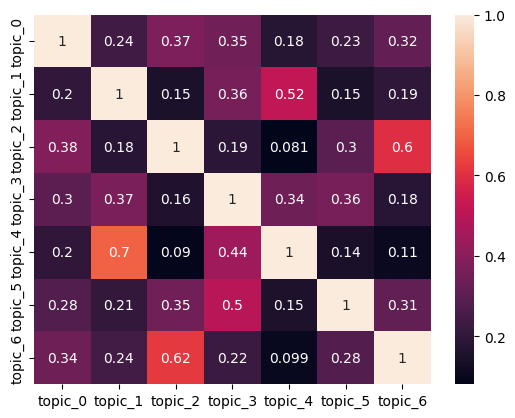

In [75]:
wwt_tfidf_4.show_intersection_of_topics()

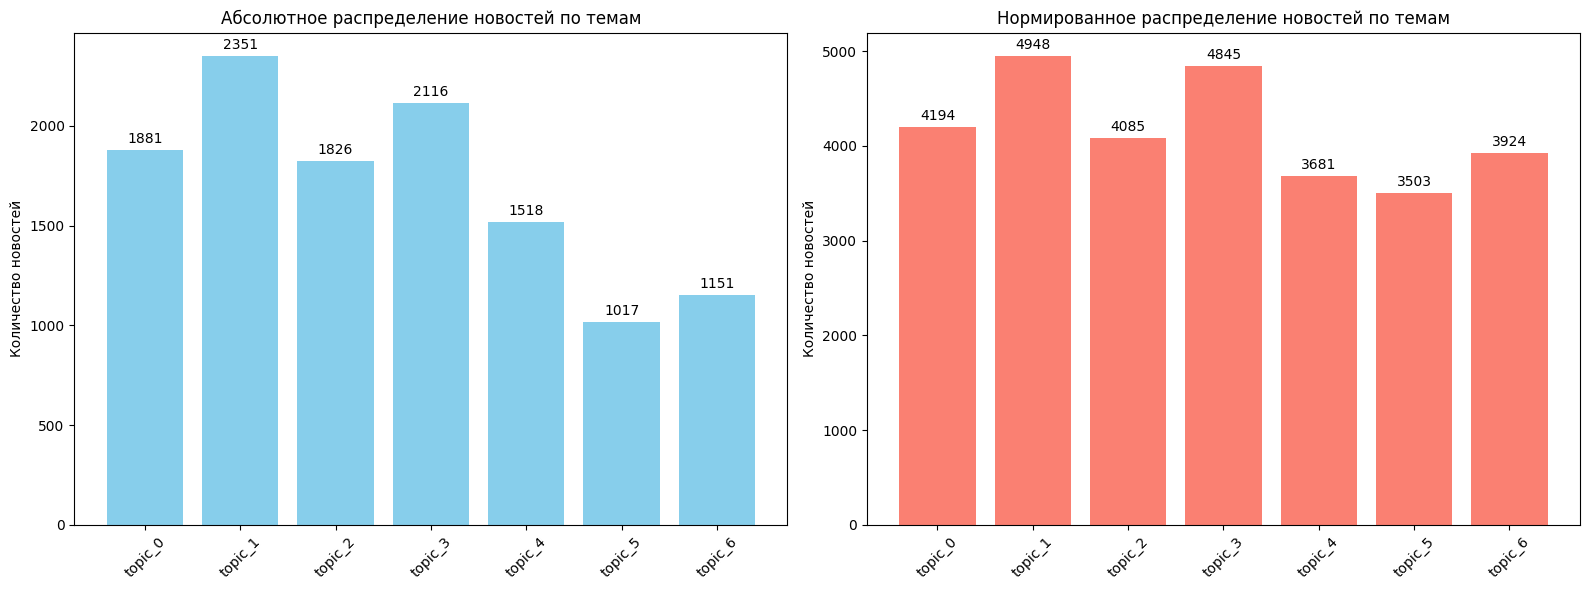

In [76]:
wwt_tfidf_4.show_number_of_news_in_topics()

In [77]:
wwt_tfidf_4.show_difference_between_distributions()

84.89881956155143


Сохранение размеченных данных

In [78]:
wwt_tfidf_4.save_labeled_news("./labeled_tfidf_4_news.xlsx")

## Модель с tfidf стоп-словами 5 процентов

Создаём экземпляр класса

In [79]:
theta_tfidf_5_path = "./drive/MyDrive/theta_tfidf_5.xlsx"
model_tfidf_5_path = "./drive/MyDrive/model_tfidf_5"
news_tfidf_5_path = "./prepeared_news_with_tfidf_5.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_5 = Worker_with_topics(theta_tfidf_5_path, model_tfidf_5_path, news_tfidf_5_path, news_with_true_distribution_path)

Полученные характеристики

In [80]:
wwt_tfidf_5.show_topics_words_cores()

topic_0: ['наука', 'язык', 'лаборатория', 'учёный', 'экономический', 'институт', 'преподаватель', 'конференция', 'кафедра', 'работать']
topic_1: ['вуз', 'курс', 'хороший', 'онлайн', 'учиться', 'команда', 'работать', 'мир', 'рейтинг', 'студенческий']
topic_2: ['социальный', 'общество', 'вопрос', 'проблема', 'гу', 'центр', 'гражданский', 'право', 'государственный', 'организация']
topic_3: ['бизнес', 'система', 'обучение', 'международный', 'место', 'управление', 'направление', 'компания', 'технология', 'центр']
topic_4: ['олимпиада', 'вуз', 'конкурс', 'получить', 'участник', 'абитуриент', 'школьник', 'класс', 'победитель', 'возможность']
topic_5: ['область', 'экономический', 'технология', 'знание', 'уровень', 'преподаватель', 'компания', 'международный', 'наука', 'деятельность']


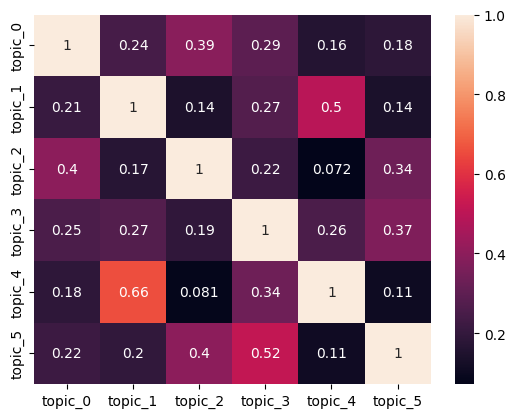

In [81]:
wwt_tfidf_5.show_intersection_of_topics()

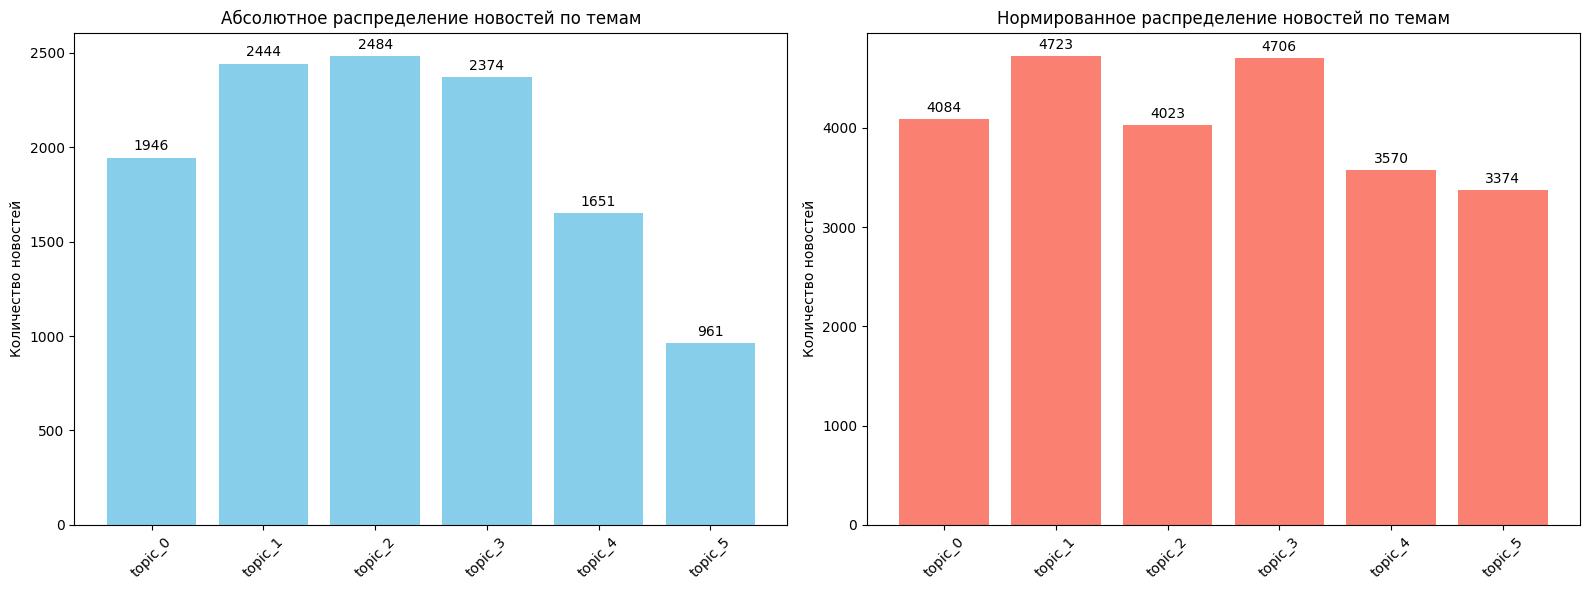

In [82]:
wwt_tfidf_5.show_number_of_news_in_topics()

In [83]:
wwt_tfidf_5.show_difference_between_distributions()

83.17032040472175


Сохранение размеченных данных

In [84]:
wwt_tfidf_5.save_labeled_news("./labeled_tfidf_5_news.xlsx")

## Модель с tfidf стоп-словами 6 процентов

Создаём экземпляр класса

In [85]:
theta_tfidf_6_path = "./drive/MyDrive/theta_tfidf_6.xlsx"
model_tfidf_6_path = "./drive/MyDrive/model_tfidf_6"
news_tfidf_6_path = "./prepeared_news_with_tfidf_6.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_6 = Worker_with_topics(theta_tfidf_6_path, model_tfidf_6_path, news_tfidf_6_path, news_with_true_distribution_path)

Полученные характеристики

In [86]:
wwt_tfidf_6.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'институт', 'учёный', 'язык', 'конференция', 'анализ', 'курс', 'преподаватель', 'работать']
topic_1: ['вуз', 'онлайн', 'курс', 'хороший', 'учиться', 'рейтинг', 'работать', 'студенческий', 'мир', 'образовательный']
topic_2: ['общество', 'социальный', 'проблема', 'вопрос', 'центр', 'гражданский', 'гу', 'рост', 'организация', 'политический']
topic_3: ['бизнес', 'обучение', 'место', 'система', 'международный', 'направление', 'технология', 'компания', 'управление', 'образовательный']
topic_4: ['олимпиада', 'конкурс', 'участник', 'вуз', 'получить', 'школьник', 'победитель', 'абитуриент', 'класс', 'приём']
topic_5: ['область', 'экономический', 'знание', 'технология', 'компания', 'уровень', 'деятельность', 'государственный', 'центр', 'наука']
topic_6: ['политика', 'вопрос', 'международный', 'мировой', 'рынок', 'государство', 'бизнес', 'система', 'социальный', 'экономический']


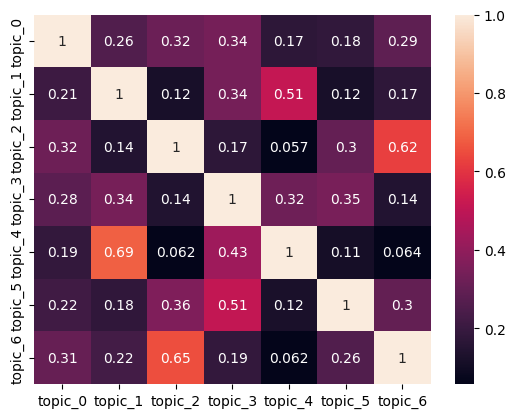

In [87]:
wwt_tfidf_6.show_intersection_of_topics()

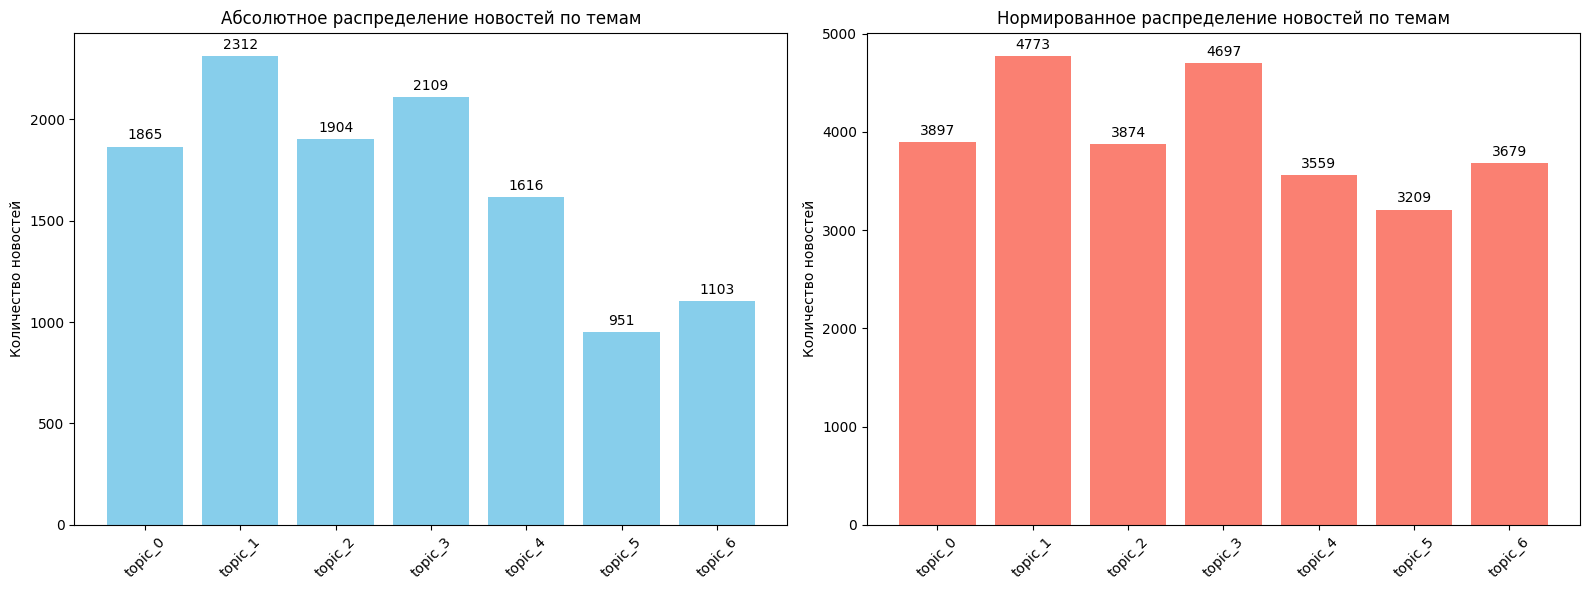

In [88]:
wwt_tfidf_6.show_number_of_news_in_topics()

In [89]:
wwt_tfidf_6.show_difference_between_distributions()

85.02529510961214


Сохранение размеченных данных

In [90]:
wwt_tfidf_6.save_labeled_news("./labeled_tfidf_6_news.xlsx")

## Модель с tfidf стоп-словами 7 процентов

Создаём экземпляр класса

In [91]:
theta_tfidf_7_path = "./drive/MyDrive/theta_tfidf_7.xlsx"
model_tfidf_7_path = "./drive/MyDrive/model_tfidf_7"
news_tfidf_7_path = "./prepeared_news_with_tfidf_7.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_7 = Worker_with_topics(theta_tfidf_7_path, model_tfidf_7_path, news_tfidf_7_path, news_with_true_distribution_path)

Полученные характеристики

In [92]:
wwt_tfidf_7.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'институт', 'курс', 'конференция', 'анализ', 'преподаватель', 'профессор']
topic_1: ['вуз', 'курс', 'онлайн', 'хороший', 'учиться', 'рейтинг', 'работать', 'студенческий', 'день', 'лекция']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'гражданский', 'рост', 'гу', 'организация', 'политический', 'право']
topic_3: ['бизнес', 'обучение', 'международный', 'компания', 'управление', 'направление', 'система', 'технология', 'образовательный', 'место']
topic_4: ['олимпиада', 'конкурс', 'участник', 'вуз', 'абитуриент', 'школьник', 'победитель', 'получить', 'класс', 'приём']
topic_5: ['область', 'государственный', 'уровень', 'деятельность', 'экономический', 'центр', 'компания', 'технология', 'знание', 'институт']
topic_6: ['политика', 'мировой', 'рынок', 'вопрос', 'международный', 'государство', 'система', 'экономический', 'отношение', 'бизнес']


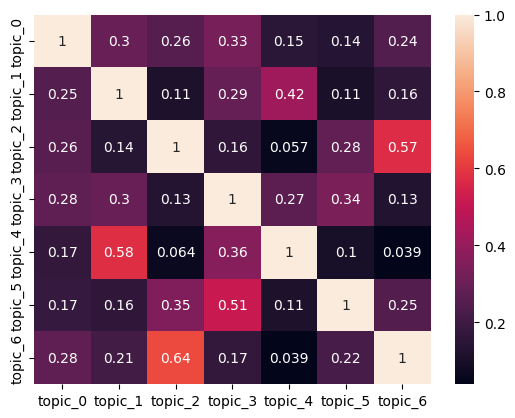

In [93]:
wwt_tfidf_7.show_intersection_of_topics()

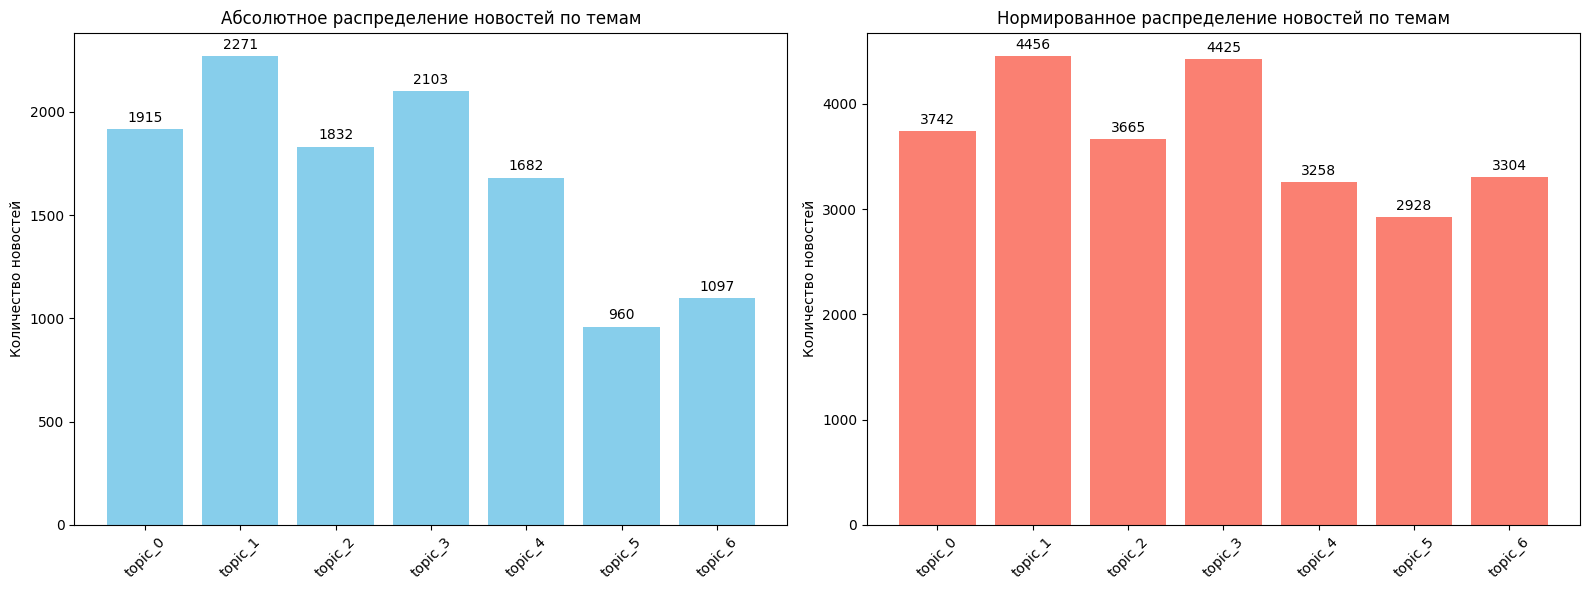

In [94]:
wwt_tfidf_7.show_number_of_news_in_topics()

In [95]:
wwt_tfidf_7.show_difference_between_distributions()

84.60370994940978


Сохранение размеченных данных

In [96]:
wwt_tfidf_7.save_labeled_news("./labeled_tfidf_7_news.xlsx")

## Модель с tfidf стоп-словами 8 процентов

Создаём экземпляр класса

In [97]:
theta_tfidf_8_path = "./drive/MyDrive/theta_tfidf_8.xlsx"
model_tfidf_8_path = "./drive/MyDrive/model_tfidf_8"
news_tfidf_8_path = "./prepeared_news_with_tfidf_8.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_8 = Worker_with_topics(theta_tfidf_8_path, model_tfidf_8_path, news_tfidf_8_path, news_with_true_distribution_path)

Полученные характеристики

In [98]:
wwt_tfidf_8.show_topics_words_cores()

topic_0: ['наука', 'учёный', 'лаборатория', 'язык', 'курс', 'институт', 'преподаватель', 'анализ', 'конференция', 'экономический']
topic_1: ['вуз', 'курс', 'онлайн', 'учиться', 'магистратура', 'студенческий', 'команда', 'хороший', 'образовательный', 'работать']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'гражданский', 'гу', 'профессор', 'рост', 'политический', 'организация']
topic_3: ['бизнес', 'обучение', 'система', 'международный', 'технология', 'компания', 'управление', 'образовательный', 'направление', 'сфера']
topic_4: ['олимпиада', 'участник', 'школьник', 'класс', 'победитель', 'получить', 'вуз', 'конкурс', 'магистратура', 'возможность']
topic_5: ['область', 'технология', 'знание', 'экономический', 'наука', 'преподаватель', 'компания', 'деятельность', 'центр', 'деловой']
topic_6: ['политика', 'вопрос', 'мировой', 'рынок', 'международный', 'государство', 'бизнес', 'система', 'экономический', 'социальный']
topic_7: ['место', 'город', 'конкурс', 'вуз', 'рейтинг', 'бал

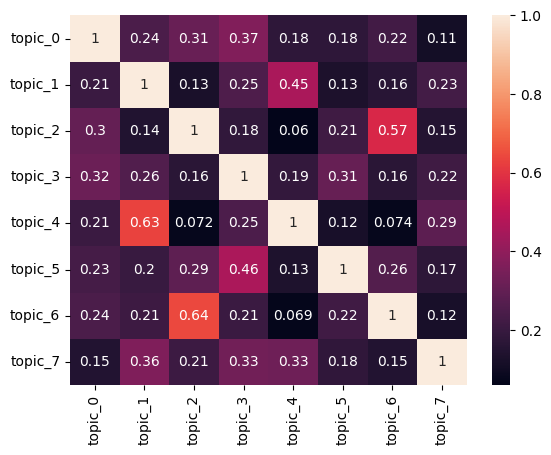

In [99]:
wwt_tfidf_8.show_intersection_of_topics()

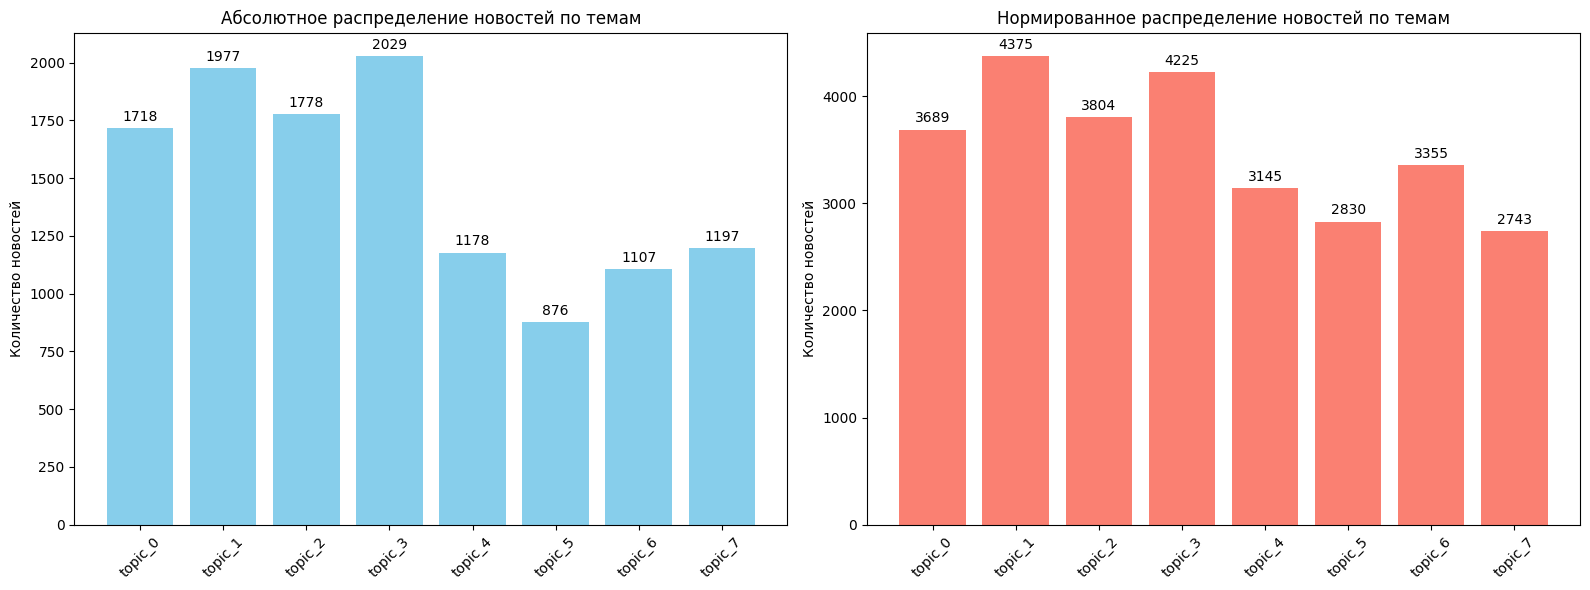

In [100]:
wwt_tfidf_8.show_number_of_news_in_topics()

In [101]:
wwt_tfidf_8.show_difference_between_distributions()

86.42495784148397


Сохранение размеченных данных

In [102]:
wwt_tfidf_8.save_labeled_news("./labeled_tfidf_8_news.xlsx")

## Модель с tfidf стоп-словами 9 процентов

Создаём экземпляр класса

In [103]:
theta_tfidf_9_path = "./drive/MyDrive/theta_tfidf_9.xlsx"
model_tfidf_9_path = "./drive/MyDrive/model_tfidf_9"
news_tfidf_9_path = "./prepeared_news_with_tfidf_9.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_9 = Worker_with_topics(theta_tfidf_9_path, model_tfidf_9_path, news_tfidf_9_path, news_with_true_distribution_path)

Полученные характеристики

In [104]:
wwt_tfidf_9.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'курс', 'преподаватель', 'институт', 'анализ', 'конференция', 'профессор']
topic_1: ['вуз', 'курс', 'онлайн', 'учиться', 'студенческий', 'хороший', 'магистратура', 'команда', 'работать', 'день']
topic_2: ['социальный', 'общество', 'проблема', 'вопрос', 'гражданский', 'рост', 'политический', 'гу', 'организация', 'сектор']
topic_3: ['бизнес', 'обучение', 'компания', 'система', 'международный', 'технология', 'управление', 'образовательный', 'сфера', 'область']
topic_4: ['олимпиада', 'участник', 'школьник', 'класс', 'победитель', 'получить', 'конкурс', 'поступление', 'магистратура', 'вуз']
topic_5: ['область', 'технология', 'знание', 'центр', 'экономический', 'деятельность', 'государственный', 'компания', 'цифровой', 'деловой']
topic_6: ['политика', 'мировой', 'рынок', 'государство', 'вопрос', 'международный', 'экономический', 'система', 'отношение', 'бизнес']
topic_7: ['место', 'вуз', 'город', 'конкурс', 'рейтинг', 'москва', 'балл', 'аби

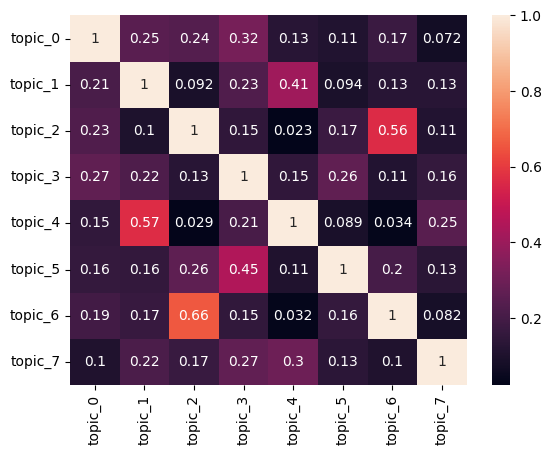

In [105]:
wwt_tfidf_9.show_intersection_of_topics()

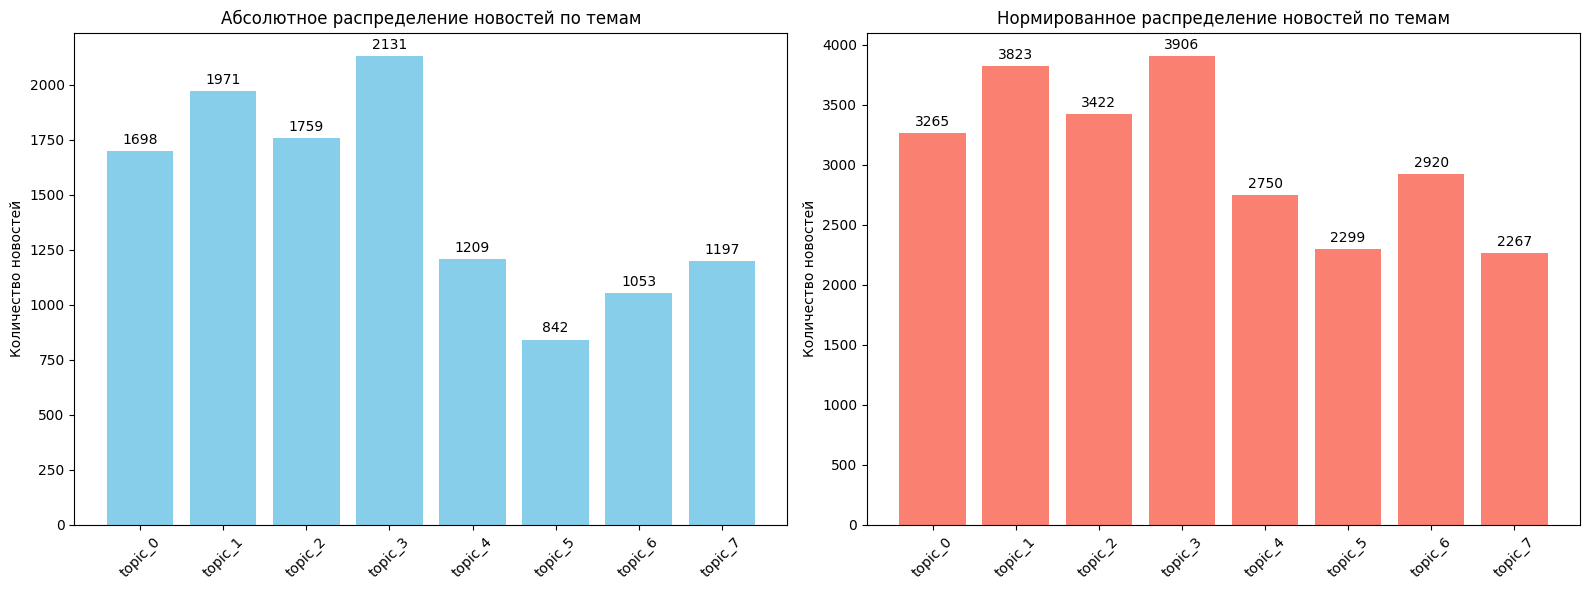

In [106]:
wwt_tfidf_9.show_number_of_news_in_topics()

In [107]:
wwt_tfidf_9.show_difference_between_distributions()

85.23608768971332


Сохранение размеченных данных

In [108]:
wwt_tfidf_9.save_labeled_news("./labeled_tfidf_9_news.xlsx")

## Модель с tfidf стоп-словами 10 процентов

Создаём экземпляр класса

In [109]:
theta_tfidf_10_path = "./drive/MyDrive/theta_tfidf_10.xlsx"
model_tfidf_10_path = "./drive/MyDrive/model_tfidf_10"
news_tfidf_10_path = "./prepeared_news_with_tfidf_10.xlsx"
news_with_true_distribution_path = "./news.xlsx"

wwt_tfidf_10 = Worker_with_topics(theta_tfidf_10_path, model_tfidf_10_path, news_tfidf_10_path, news_with_true_distribution_path)

Полученные характеристики

In [110]:
wwt_tfidf_10.show_topics_words_cores()

topic_0: ['наука', 'лаборатория', 'учёный', 'язык', 'курс', 'институт', 'преподаватель', 'анализ', 'профессор', 'конференция']
topic_1: ['курс', 'онлайн', 'вуз', 'учиться', 'студенческий', 'хороший', 'день', 'лекция', 'работать', 'команда']
topic_2: ['социальный', 'общество', 'проблема', 'гражданский', 'вопрос', 'рост', 'политический', 'гу', 'организация', 'сектор']
topic_3: ['бизнес', 'обучение', 'компания', 'международный', 'система', 'управление', 'технология', 'образовательный', 'сфера', 'область']
topic_4: ['олимпиада', 'участник', 'школьник', 'победитель', 'класс', 'конкурс', 'получить', 'поступление', 'магистратура', 'возможность']
topic_5: ['область', 'центр', 'государственный', 'технология', 'знание', 'цифровой', 'деятельность', 'организация', 'экономический', 'деловой']
topic_6: ['политика', 'мировой', 'рынок', 'государство', 'экономический', 'международный', 'вопрос', 'система', 'отношение', 'кризис']
topic_7: ['место', 'вуз', 'город', 'конкурс', 'рейтинг', 'абитуриент', 'мо

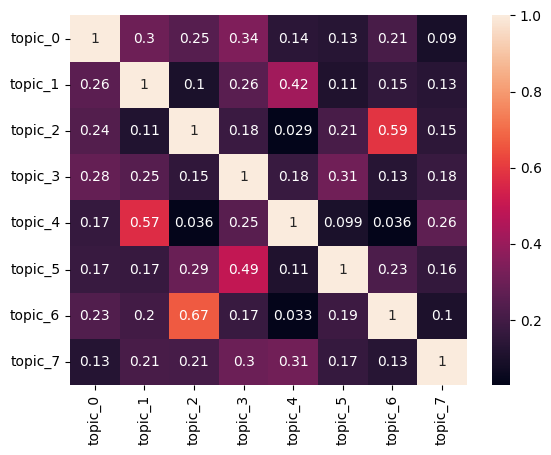

In [111]:
wwt_tfidf_10.show_intersection_of_topics()

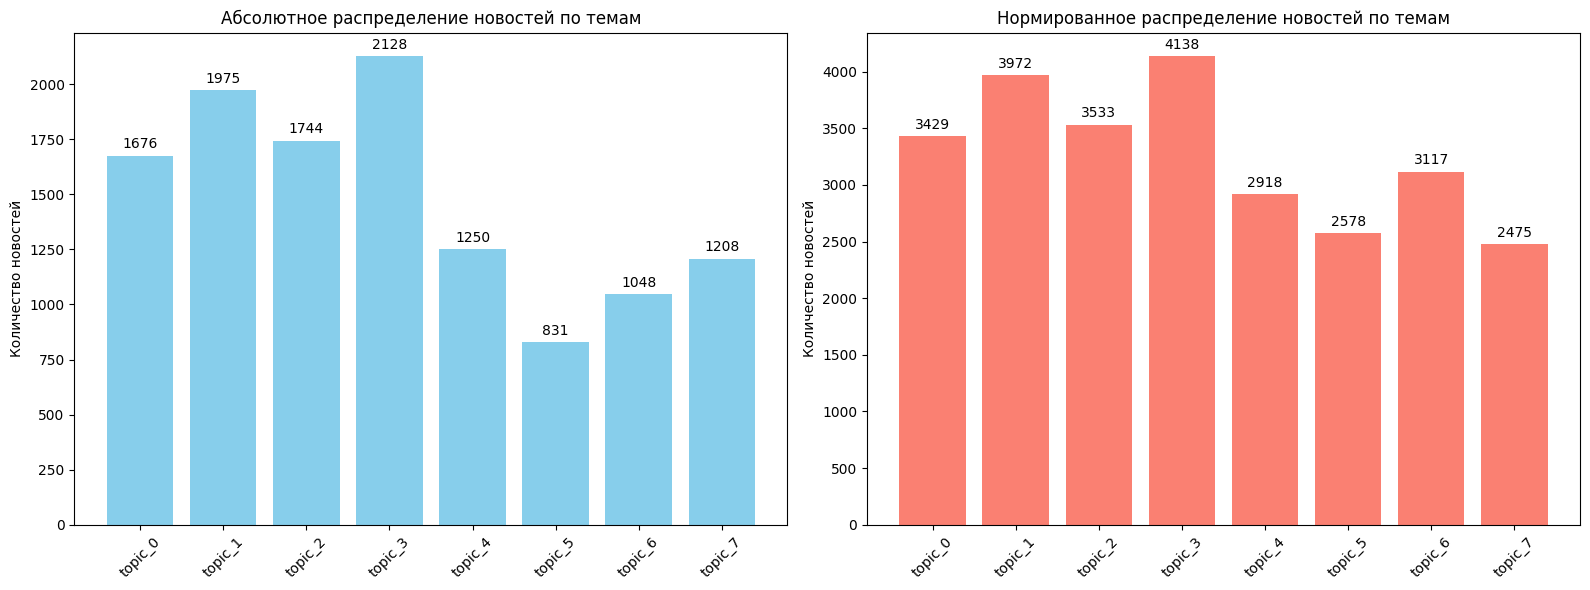

In [112]:
wwt_tfidf_10.show_number_of_news_in_topics()

In [113]:
wwt_tfidf_10.show_difference_between_distributions()

85.5902192242833


Сохранение размеченных данных

In [114]:
wwt_tfidf_10.save_labeled_news("./labeled_tfidf_10_news.xlsx")